# Testing bias metrics and mitigation algorithms on the Bank dataset

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from utility import *
sns.set_theme(style='darkgrid')

## Dataset description

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y). This dataset have been proven to be bias w.r.t. the `age` variable with a value >= 25.

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the unsensitive variables at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the unsensitive attributes are changed s.t. the correlation between the variables and the sensitive attribute _S_ is removed while keeping the ranking of the items for the classifier. In this way it is no more possible to predict the sensitive variable _S_ from the unsensitive attributes.
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier.
>
>**NB:** Categorical data must be transformed in ordered values

3. **Sampling**

> Sampling is a modified version of the Reweighing algorithm. First of all, it considered the groups made by each combinantion of the values of sensitive variables and labels. Then, for each group it computes his disparity ($\frac{size\_exp}{size\_obs}$) and samples each group untill this value becomes 1. The final dataset will be a dataset in which each group is balanced.

# Importing and exploring the dataset

In [2]:
df = pd.read_csv('bank/bank-additional-full.csv', sep=';')
for col in df.columns:
    df.drop(df[df[col] == 'unknown'].index, inplace=True)
df.loc[df['age']<25, 'age'] = 1
df.loc[df['age']!=1, 'age'] = 0

In [3]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,0,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,0,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,0,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,0,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,0,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,0,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,0,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


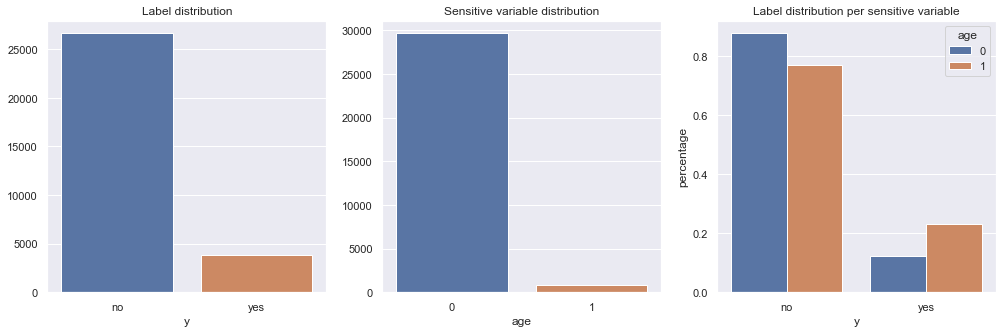

In [4]:
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(17,5))
sns.countplot(x='y', data=df, ax=ax1)
sns.countplot(x='age', data=df, ax=ax2)
sns.barplot(x='y',y='percentage',
            data=(df[['age','y']]
                 .groupby('age')['y']
                 .value_counts(normalize=True)
                 .rename('percentage')
                 .reset_index()),
            hue='age', ax=ax3
           )
ax1.set_title('Label distribution')
ax1.set_ylabel('')
ax2.set_ylabel('')
ax2.set_title('Sensitive variable distribution')
ax3.set_title('Label distribution per sensitive variable')
plt.show()

We are in an **unbalanced bias** case.

In [5]:
le = LabelEncoder()
dummy_cols = ['default', 'housing', 'loan', 'y']
for col in dummy_cols:
    df[col] = le.fit_transform(df[col])

In [6]:
cat_cols = ['job', 'marital', 'education', 'contact', 'month', 'day_of_week', 'poutcome']

In [7]:
for col in cat_cols:
    df = df.join(pd.get_dummies(df[col], prefix=col)).drop(col, axis=1)

In [8]:
priv_group=[{'age':1}]
unpriv_group=[{'age':0}]

In [9]:
bank = BinaryLabelDataset(df=df, label_names=['y'], protected_attribute_names=['age'])

# Bias dataset case

In [10]:
metrics = compute_dataset_fairness_metrics(bank, unpriv_group, priv_group)

Disparate Impact = 0.5364
Statistical Parity = -0.1068


Balanced accuracy: 0.8629
Statistical parity difference: -0.2126
Disparate impact: 0.5324
Average odds difference: -0.1072
Equal opportunity difference: -0.0560
Theil index: 0.0538


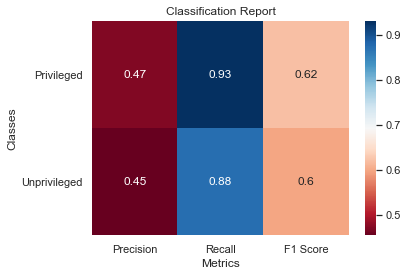

In [11]:
bias_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    bank, priv_group, unpriv_group)

# Reweighing

In [12]:
rw = Reweighing(unpriv_group, priv_group)
rw_data = bank.copy()
rw_data = rw.fit_transform(rw_data)

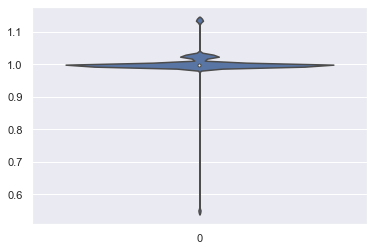

In [13]:
sns.violinplot(data=rw_data.instance_weights)
plt.show()

In [14]:
metrics = compute_dataset_fairness_metrics(rw_data, unpriv_group, priv_group)

Disparate Impact = 1.0000
Statistical Parity = -0.0000


Balanced accuracy: 0.8621
Statistical parity difference: -0.0398
Disparate impact: 0.8839
Average odds difference: -0.0147
Equal opportunity difference: 0.0212
Theil index: 0.0541


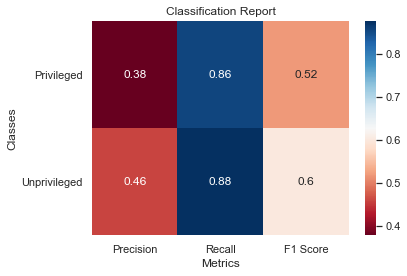

In [15]:
rw_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_data, priv_group, unpriv_group)

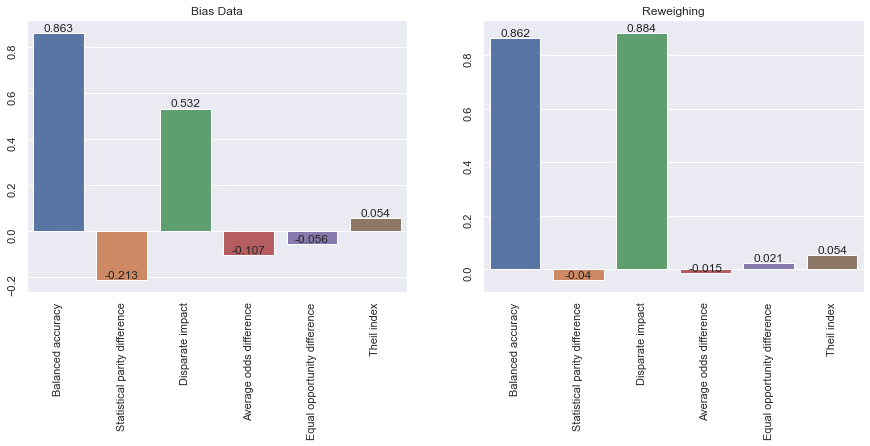

In [16]:
plot_metrics_comparison(bias_class, rw_class, 'Bias Data', 'Reweighing')
plt.show()

# Modified Reweighing (Sampling)

Original dataset size: (30488,55)
Sampled dataset size: (30555,55)


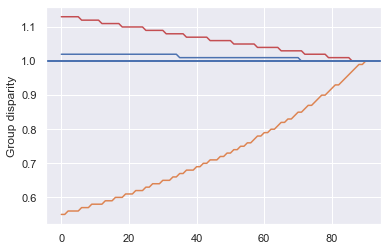

In [17]:
sampled_data = sample_dataset(
    df.copy(),
    [df['age']==0, df['age']==1],
    df['y']==1,
    df['y']==0,
    ['age'], 'y', round_level=2)

In [18]:
metrics = compute_dataset_fairness_metrics(sampled_data, unpriv_group, priv_group)

Disparate Impact = 0.9913
Statistical Parity = -0.0011


Balanced accuracy: 0.8625
Statistical parity difference: -0.0440
Disparate impact: 0.8658
Average odds difference: -0.0037
Equal opportunity difference: 0.0492
Theil index: 0.0539


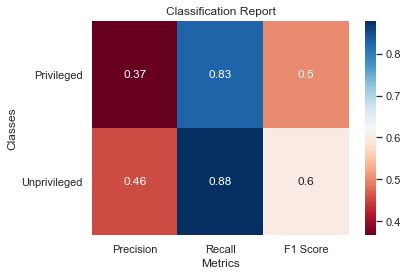

In [19]:
sampled_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    sampled_data, priv_group, unpriv_group)

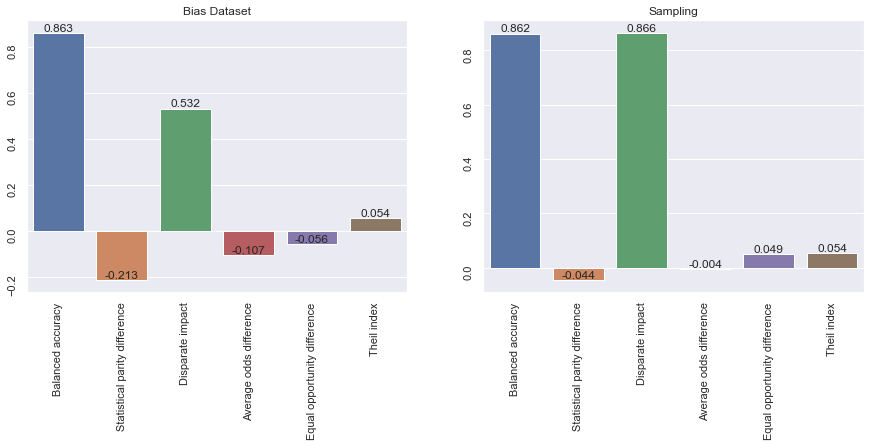

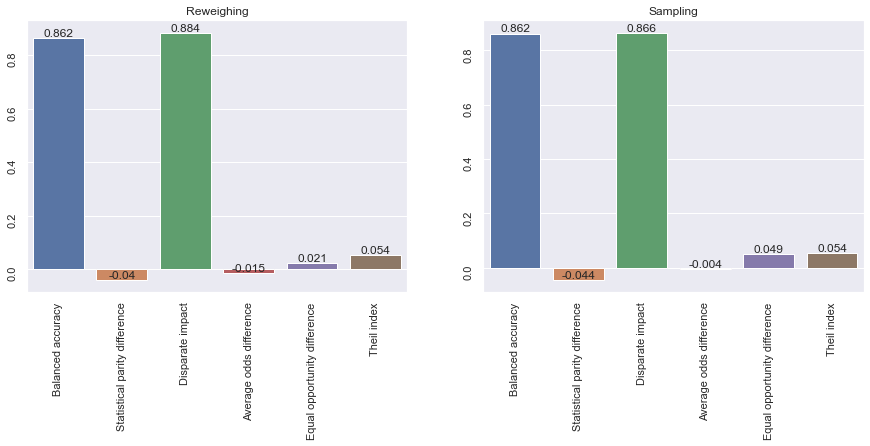

In [20]:
plot_metrics_comparison(bias_class, sampled_class, 'Bias Dataset', 'Sampling')
plot_metrics_comparison(rw_class, sampled_class, 'Reweighing', 'Sampling')
plt.show()

# Disparate Impact Remover

In [21]:
dir_data = bank.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)
di = DisparateImpactRemover(sensitive_attribute='age')
dir_data = di.fit_transform(dir_data)

In [22]:
metrics = compute_dataset_fairness_metrics(dir_data, unpriv_group, priv_group)

Disparate Impact = 0.5364
Statistical Parity = -0.1068


Balanced accuracy: 0.8541
Statistical parity difference: -0.3698
Disparate impact: 0.3888
Average odds difference: -0.2409
Equal opportunity difference: -0.1438
Theil index: 0.0560


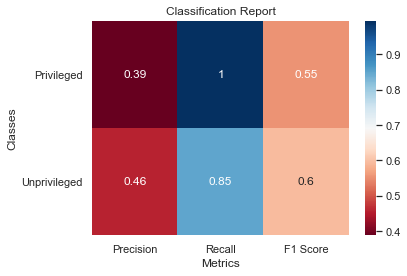

In [23]:
dir_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    dir_data, priv_group, unpriv_group, sensitive_attributes=['age'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


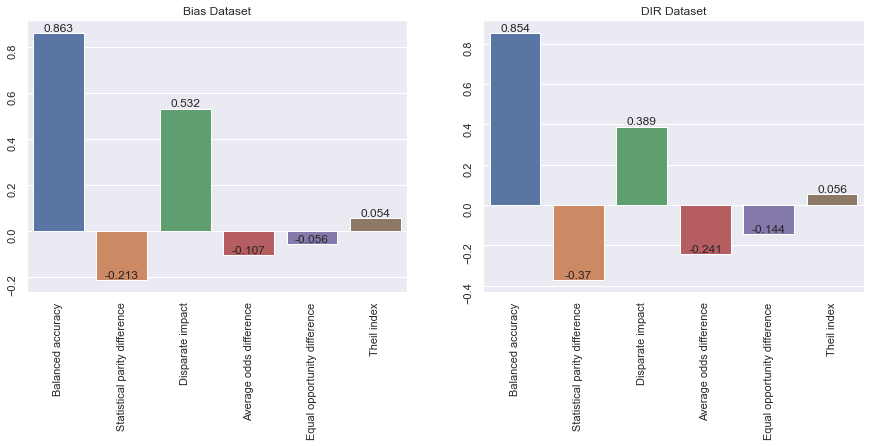

In [24]:
plot_metrics_comparison(bias_class, dir_class, 'Bias Dataset', 'DIR Dataset')
plt.show()

# Reweighing + DIR

In [25]:
rw_dir = dir_data.copy()
rw = Reweighing(unpriv_group, priv_group)
rw_dir = rw.fit_transform(rw_dir)

In [26]:
metrics = compute_dataset_fairness_metrics(rw_dir, unpriv_group, priv_group)

Disparate Impact = 1.0000
Statistical Parity = -0.0000


Balanced accuracy: 0.8521
Statistical parity difference: -0.3059
Disparate impact: 0.4400
Average odds difference: -0.2361
Equal opportunity difference: -0.1419
Theil index: 0.0560


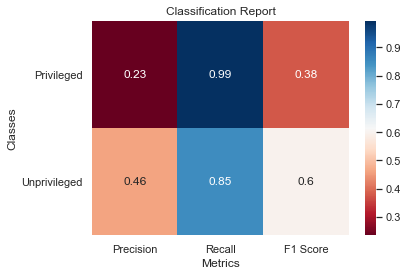

In [27]:
rw_dir_class = classify(
 make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_dir, priv_group, unpriv_group, sensitive_attributes=['age'])

# Algorithms comparison

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias,-0.1072,0.8629,0.5324,-0.0560,-0.2126,0.0538
DIR,-0.2409,0.8541,0.3888,-0.1438,-0.3698,0.0560
Reweighed,-0.0147,0.8621,0.8839,0.0212,-0.0398,0.0541
Reweighing + DIR,-0.2361,0.8521,0.4400,-0.1419,-0.3059,0.0560
Sampled,-0.0037,0.8625,0.8658,0.0492,-0.0440,0.0539


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


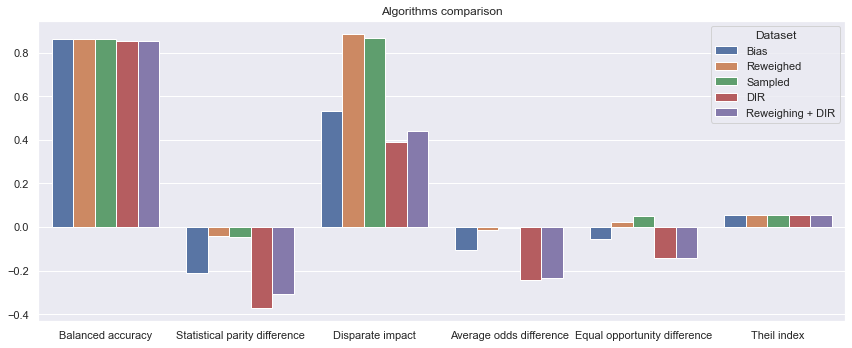

In [28]:
plot_syntesis(merge_datasets({
    'Bias': bias_class,
    'Reweighed': rw_class,
    'Sampled': sampled_class,
    'DIR': dir_class,
    'Reweighing + DIR': rw_dir_class,
}), 'Algorithms comparison')
plt.savefig('bank_comparison.pdf')
plt.show()